In [40]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import tikzplotlib

from src.config import SAT_TEST_SEQ, POLICIES

COLOURS = ["blue", "orange", "green", "red"]
ENCODING_DIR = "./results/encoding"
POLICY_DIR = "./results/policy"
SEARCH_DIR = "./results/search"
SOLVER_DIR = "./results/solver"
TEX_DIR = "./tex"
SEQUENCES_DIR = "./input"

In [41]:
# Toggle what results to show
SHOW_POLICY_RESULTS = False
SHOW_SAT_RESULTS = False
SHOW_SOLVER_RESULTS = False
SHOW_CONTACT_RESULTS = True

In [42]:
def get_sequence(seq_file: str) -> str:
    with open(os.path.join(SEQUENCES_DIR, seq_file), "r") as f:
        # Return the last "\n"
        return f.readline()[:-1]

def get_max_contacts(s: str, dim: int) -> int:
    n = len(s)
    max_adj = 2 if dim == 2 else 4
    total = 0
    for i in range(n - 3):
        if s[i] == "1":
            total += min(max_adj, s[i+3:n:2].count("1"))
    return total

def get_max_contacts_for_all(result_dicts: list[dict], dim: int):
    # Loop through all of the results and add a new key for max_contacts
    for result in result_dicts:
        result["max_contacts"] = get_max_contacts(result["sequence"], dim)

# Get a list of the results from a directory
def get_result_dicts(dir_path: str) -> list[dict]:
    results = []
    for filename in filter(lambda x: x.endswith(".csv"), os.listdir(dir_path)):
        # Open the csv file
        print(filename)
        file_dict = pd.read_csv(os.path.join(dir_path, filename)).to_dict()
        # For each header in the csv where (key1=name,val1=dict(key=row_num,val=val_at_row))
        valid = True
        for key1, val1 in file_dict.items():
            # If the value is a string, convert from a dict of strings to 1 string
            if len(val1) == 0:
                valid = False
            if type(val1[0]) == str:
                file_dict[key1] = val1[0]
            # Else find the average of the values
            else:
                values = [v for v in val1.values()]
                file_dict[key1] = np.mean(values)
        if valid:
            file_dict["sequence"] = get_sequence(filename.split("_")[0])
            results.append(file_dict)
    return results

# Helper functions for working with return value of the above function
def get_all_vars_for(result_dicts: list[dict], var_name: str) -> list:
    return sorted(set(x[var_name] for x in result_dicts))

def filter_by(result_dicts: list[dict], var_name: str, var) -> list:
    return [x for x in result_dicts if x[var_name] == var]

# Given the results, plot the change in time per length for the independent variable
def plot_data(result_dicts: list[dict], indp_var: str):
    # TODO: Complete function to plot data to compare indp vars, where x axis is length, y axis is time taken
    mapped_results: dict[str, list[dict]] = {}
    fig, ax_left = plt.subplots(figsize=(16, 10))
    ax_right = ax_left.twinx()

    for r in result_dicts:
        key = r[indp_var]
        mapped_results[key] = mapped_results.get(key, []) + [r]

    # Loop through each 
    for i, (var, results) in enumerate(mapped_results.items()):
        data = []
        incl = ["len", "encode_time", "total_time", "sat_time"]
        for result in results:
            data.append({i: result[i] for i in incl})
        data.sort(key=lambda x:x["len"])

# Policy Test Results

The following code compares for each policy the best combination of `[search-policy][sat-solver][encoding-version]`

In [43]:
if SHOW_POLICY_RESULTS:
    #  Compare the performance of each (policy, solver, version) combination
    results = get_result_dicts(POLICY_DIR)
    policies = get_all_vars_for(results, "policy")
    solvers = get_all_vars_for(results, "solver")
    vers = get_all_vars_for(results, "ver")
    lengths = get_all_vars_for(results, "len")[:-1] # Ignore last length since not everything was tested
    print(lengths)

    # Results
    results_each_len: dict[str, dict[str, dict[list[float]]]] = {
        policy: {
            solver: {
                ver: [] for ver in vers
            } for solver in solvers
        } for policy in policies
    }

    print(" " * (1 + len(policies[0]) + len(solvers[0])), "   \t", "[v0,      v1,     v2]")
    # Get the times for all policies
    for policy in policies:
        policy_times = []
        # Get the times for all solvers
        for solver in solvers:
            policy_solver_results = filter_by(filter_by(results, "policy", policy), "solver", solver)
            ver_results = []
            # Get the time for all versions
            for ver in vers:
                policy_solver_ver_results = filter_by(policy_solver_results, "ver", ver)
                avg_ver_results = np.mean([x["total_time"] for x in policy_solver_ver_results])
                ver_results.append(round(avg_ver_results, 4))

                # Get the time for all lengths
                for length in lengths:
                    length_results = filter_by(policy_solver_ver_results, "len", length)
                    results_each_len[policy][solver][ver].append(np.mean([x["total_time"] for x in length_results]))

            # Print out the times for current policy and solver
            ver_avg = round(np.mean(ver_results), 4)
            policy_times.append(ver_avg)
            print(policy, solver, "   \t", ver_results, f"\t{ver_avg = }")
        
        # Print out the average time for the policy
        policy_avg = round(np.mean(policy_times), 4)
        print(f"{policy_avg = }")
        print()

    # Plot the times taken
    plt.figure(figsize=(14, 10))
    for p in policies:
        # plt.plot(lengths, results_each_len[p]["kissat"][vers[0]])
        # TODO: Show average for all solvers and all encodings
        times = []
        
        for l in lengths:
            length_times = []
            for s in solvers:
                for v in vers:
                    print(l)
                    length_times.append(results_each_len[p][s][v][int(l) - 1])
            times.append(sum(length_times) / len(length_times))
        plt.plot(lengths, times, label=p.replace("_", " "))
    plt.legend()
    plt.yscale("log")
    tikzplotlib.save(os.path.join(TEX_DIR, "policy.tex"))
    plt.show()

# SAT Test Results

The following code shows how long it takes for a kissat to solve for different goal contacts.

In [44]:
if SHOW_SAT_RESULTS:
    with open(SAT_TEST_SEQ.replace("input", "results/sat") + ".json") as f:
        data = json.load(f)
        plt.figure(figsize=(14, 10))
        times = data["times"]
        n = len(times)
        calls = [i + 1 for i in range(n)]
        plt.bar(calls, times)
        # plt.yscale("log")
        tikzplotlib.save(os.path.join(TEX_DIR, "sat.tex"))
        plt.show()
        print(f"{times = }")
        for policy in POLICIES:
            calls = data[policy]
            total = sum([times[i - 1] for i in calls])
            print(policy, total, len(calls), calls)

# Solver Test Results

The following code compares how long it takes to solve for different combinations of solvers and encodings

In [45]:
if SHOW_SOLVER_RESULTS:
    #  Compare the performance of each (solver, version) combination
    results = get_result_dicts(SOLVER_DIR)
    solvers = get_all_vars_for(results, "solver")
    vers = get_all_vars_for(results, "ver")
    lengths = get_all_vars_for(results, "len")[:-1]

    # Results
    results_each_len: dict[str, dict[str, dict[list[float]]]] = {
        solver: {
            ver: [] for ver in vers
        } for solver in solvers
    }

    print(" " * (1 + len(solvers[0])), "   \t", "[v0,      v1,     v2]")
    # Get the times for all solvers
    for solver in solvers:
        solver_results = filter_by(results, "solver", solver)
        ver_results = []
        # Get the time for all versions
        for ver in vers:
            solver_ver_results = filter_by(solver_results, "ver", ver)
            avg_ver_results = np.mean(
                [x["total_time"] for x in solver_ver_results])
            ver_results.append(round(avg_ver_results, 4))

            # Get the time for all lengths
            for length in lengths:
                length_results = filter_by(
                    solver_ver_results, "len", length)
                results_each_len[solver][ver].append(
                    np.mean([x["total_time"] for x in length_results]))

        # Print out the times for current policy and solver
        ver_avg = round(np.mean(ver_results), 4)
        print(solver, "   \t", ver_results, f"\t{ver_avg = }")

    # Plot the times taken
    plt.figure(figsize=(14, 10))
    for s in solvers:
        plt.plot(lengths, results_each_len[p]["kissat"]
                 [vers[2]], label=p.replace("_", " "))
    plt.legend()
    plt.yscale("log")
    tikzplotlib.save(os.path.join(TEX_DIR, "policy.tex"))
    plt.show()


In [46]:
all_results = get_result_dicts(ENCODING_DIR)

1bbo01_2d_v0_kis_lsp.csv
1bbo01_2d_v1_kis_lsp.csv
1bbo01_2d_v2_kis_lsp.csv
1bbo01_2d_v3_kis_lsp.csv
1be3K0_2d_v0_kis_lsp.csv
1be3K0_2d_v1_kis_lsp.csv
1be3K0_2d_v2_kis_lsp.csv
1be3K0_2d_v3_kis_lsp.csv
1byyA0_2d_v0_kis_lsp.csv
1byyA0_2d_v1_kis_lsp.csv
1byyA0_2d_v2_kis_lsp.csv
1byyA0_2d_v3_kis_lsp.csv
1byyA0_3d_v1_kis_lsp.csv
1byyA0_3d_v2_kis_lsp.csv
1byyA0_3d_v3_kis_lsp.csv
1f8vF0_2d_v0_kis_lsp.csv
1f8vF0_2d_v1_kis_lsp.csv
1f8vF0_2d_v2_kis_lsp.csv
1f8vF0_2d_v3_kis_lsp.csv
1f8vF0_3d_v1_kis_lsp.csv
1f8vF0_3d_v2_kis_lsp.csv
1f8vF0_3d_v3_kis_lsp.csv
1gd2J0_2d_v0_kis_lsp.csv
1gd2J0_2d_v1_kis_lsp.csv
1gd2J0_2d_v2_kis_lsp.csv
1gd2J0_2d_v3_kis_lsp.csv
1gd2J0_3d_v0_kis_lsp.csv
1gd2J0_3d_v1_kis_lsp.csv
1gd2J0_3d_v2_kis_lsp.csv
1gd2J0_3d_v3_kis_lsp.csv
1i4oD0_2d_v0_kis_lsp.csv
1i4oD0_2d_v1_kis_lsp.csv
1i4oD0_2d_v2_kis_lsp.csv
1i4oD0_2d_v3_kis_lsp.csv
1i4oD0_3d_v1_kis_lsp.csv
1i4oD0_3d_v2_kis_lsp.csv
1i4oD0_3d_v3_kis_lsp.csv
1meyF2_2d_v0_kis_lsp.csv
1meyF2_2d_v1_kis_lsp.csv
1meyF2_2d_v2_kis_lsp.csv


[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 35, 37, 38, 39, 40, 45]


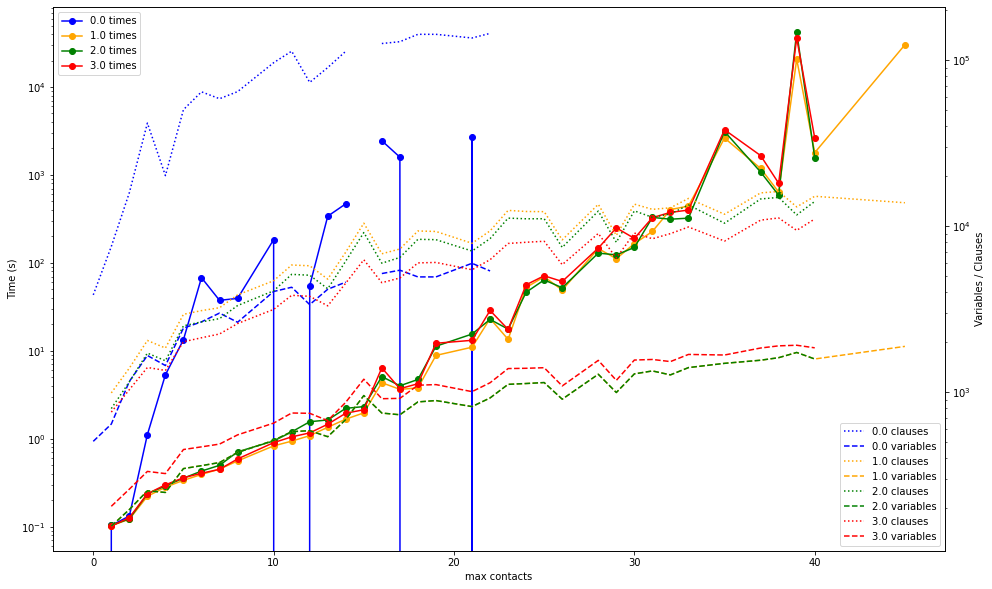

In [48]:
# TODO: length-16-1_3d_v0_NAs_NAp.csv

dimension = 3
results = filter_by(all_results, "dim", dimension)
vers = get_all_vars_for(results, "ver")
lengths = get_all_vars_for(results, "len")[:-1]
dims = get_all_vars_for(results, "dim")
get_max_contacts_for_all(results, dimension)
max_contacts_list = get_all_vars_for(results, "max_contacts")[:-1]
print(max_contacts_list)

# Currently is NaN for length = 12, v = 0
yscale_mode = "log"
xs = max_contacts_list
xs_col_name = "max_contacts"

fig, ax_left = plt.subplots(figsize=(16, 10))
ax_right = ax_left.twinx()
for i, ver in enumerate(vers):
    ver_results = filter_by(results, "ver", ver)
    x_times, x_cls, x_vars = [], [], []
    x_times_std, x_cls_std, x_vars_std = [], [], []
    for x in xs:
        ver_len_result = filter_by(ver_results, xs_col_name, x)
        times = [x["total_time"] for x in ver_len_result]
        clauses = [x["cls"] for x in ver_len_result]
        variables = [x["vars"] for x in ver_len_result]
        x_times.append(np.mean(times))
        x_cls.append(np.mean(clauses))
        x_vars.append(np.mean(variables))
        x_times_std.append(np.std(times))
        x_cls_std.append(np.std(clauses))
        x_vars_std.append(np.std(variables))
    
    # Plot bars
    ax_left.plot(xs, x_times, color=COLOURS[i], marker="o", label=f"{ver} times")
    ax_right.plot(xs, x_cls, ":", color=COLOURS[i], label=f"{ver} clauses")
    ax_right.plot(xs, x_vars, "--", color=COLOURS[i], label=f"{ver} variables")

    # Show standard deviation
    # ax_left.fill_between(lengths, np.array(length_times) + np.array(length_times_std), np.array(length_times) - np.array(length_times_std), alpha=0.1)

ax_left.set_yscale(yscale_mode)
ax_left.set_ylabel("Time (s)")

ax_right.set_yscale(yscale_mode)
ax_right.set_ylabel("Variables / Clauses")
# ax_left.grid(True, which="minor")
ax_left.set_xlabel(xs_col_name.replace("_", " "))

ax_left.legend()
ax_right.legend(loc="lower right")
plt.show()